In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.models import Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix

Using TensorFlow backend.


In [2]:
econ = pd.read_csv("ECONOMIC.csv")
exc = pd.read_csv("EXCHANGE.csv")
mkt = pd.read_csv("MARKET.csv")
per = pd.read_csv("PER.csv")
kos = pd.read_csv("KOSPI_국면분석.csv")

In [3]:
kos['날짜']= pd.to_datetime(kos['날짜']) 
kos.index = kos['날짜']
kos.drop(kos.columns[10:], axis = 1, inplace = True)
kos.drop(kos.columns[0], axis = 1, inplace = True)
kos.head()

,Y,지수시가,지수고가,지수저가,지수종가,거래량,거래대금,상장주식수,시가총액
날짜,,,,,,,,,
2001-01-02,상승,503.31,521.34,500.97,520.95,231014600,1223328,19638887,191252891
2001-01-03,상승,512.74,524.58,510.70,521.43,324584400,1583403,19633559,191363161
2001-01-04,상승,551.53,567.16,550.91,558.02,444540900,2984761,19634734,204074166
2001-01-05,상승,559.54,581.41,555.40,580.85,578286000,3569582,19637038,212089180
2001-01-08,상승,573.72,587.91,572.48,586.65,558645100,2948092,19630735,214231273


In [4]:
kos.dtypes

Y         object
지수시가     float64
지수고가     float64
지수저가     float64
지수종가     float64
거래량        int64
거래대금       int64
상장주식수      int64
시가총액       int64
dtype: object

In [5]:
# 지수종가를 가지고 예측 프로그램 만들기

scaler = MinMaxScaler() # 해당 값들을 MinMaxScaler를 활용해 변형하기
kos[['지수종가']] = scaler.fit_transform(kos[['지수종가']])
print(kos)

             Y     지수시가     지수고가     지수저가      지수종가        거래량     거래대금  \
날짜                                                                        
2001-01-02  상승   503.31   521.34   500.97  0.024509  231014600  1223328   
2001-01-03  상승   512.74   524.58   510.70  0.024734  324584400  1583403   
2001-01-04  상승   551.53   567.16   550.91  0.041917  444540900  2984761   
2001-01-05  상승   559.54   581.41   555.40  0.052638  578286000  3569582   
2001-01-08  상승   573.72   587.91   572.48  0.055362  558645100  2948092   
2001-01-09  상승   583.85   589.92   572.55  0.056898  558967700  2833998   
2001-01-10  상승   586.63   593.86   560.81  0.043228  642378200  3285030   
2001-01-11  상승   568.26   570.57   557.86  0.043688  518788600  2721732   
2001-01-12  상승   578.95   601.09   578.95  0.055935  713787700  3980149   
2001-01-15  상승   595.06   608.22   588.87  0.061162  611961800  3407840   
2001-01-16  하락   600.68   608.51   588.42  0.063238  606278900  3352424   
2001-01-17  상승   600.75  

In [6]:
price = kos['지수종가'].values.tolist() #지수종가 데이터를 price라는 변수에 담기
print(price)

[0.02450890613920159, 0.024734318573514935, 0.04191732059753078, 0.05263849950456223, 0.055362233085849255, 0.056897855294609334, 0.04322753037197746, 0.043687747425367296, 0.05593515635639584, 0.061161907177037955, 0.06323758000967389, 0.05967324589209322, 0.06353343382971027, 0.07092038714585591, 0.07452229000248894, 0.05774784801566618, 0.060006668451181744, 0.057564700412786496, 0.0700422178705099, 0.06740771004447194, 0.06561380275472778, 0.05184485989208376, 0.055329360439178576, 0.0504501204547696, 0.05767271053756168, 0.05950418656635814, 0.061255829024668584, 0.06105859314464429, 0.06343011979731666, 0.06333619794968604, 0.0639419938669033, 0.06006771765214164, 0.06573590115664751, 0.05906275388249432, 0.05384069915423373, 0.05389235617043053, 0.05473765279910586, 0.051098181203420634, 0.051347074099641676, 0.042584165715707945, 0.04537364459033638, 0.04667446218001997, 0.04690457070671494, 0.05190121300066214, 0.045552096100834494, 0.035826488778687215, 0.02780556299103515, 0

In [7]:
# 5일치의 데이터를 가지고 다음 데이터를 예측하도록 모델링 (5일치 만큼 x에 값을 넣어주고, 6일 째에는 y 데이터를 넣어주는 방식)

window_size = 5
x = []
y = []

for i in range(len(price) - window_size):
    x.append([price[i + j] for j in range(window_size)])
    y.append(price[window_size + i])
    
print(x)
print(y)

[[0.02450890613920159, 0.024734318573514935, 0.04191732059753078, 0.05263849950456223, 0.055362233085849255], [0.024734318573514935, 0.04191732059753078, 0.05263849950456223, 0.055362233085849255, 0.056897855294609334], [0.04191732059753078, 0.05263849950456223, 0.055362233085849255, 0.056897855294609334, 0.04322753037197746], [0.05263849950456223, 0.055362233085849255, 0.056897855294609334, 0.04322753037197746, 0.043687747425367296], [0.055362233085849255, 0.056897855294609334, 0.04322753037197746, 0.043687747425367296, 0.05593515635639584], [0.056897855294609334, 0.04322753037197746, 0.043687747425367296, 0.05593515635639584, 0.061161907177037955], [0.04322753037197746, 0.043687747425367296, 0.05593515635639584, 0.061161907177037955, 0.06323758000967389], [0.043687747425367296, 0.05593515635639584, 0.061161907177037955, 0.06323758000967389, 0.05967324589209322], [0.05593515635639584, 0.061161907177037955, 0.06323758000967389, 0.05967324589209322, 0.06353343382971027], [0.061161907177

In [8]:
# 데이터를 보기 좋게 정렬하기 (5개의 데이터, y 데이터 1개씩)

x = np.asarray(x)
y = np.asarray(y)
print(x)
print(y)

[[0.02450891 0.02473432 0.04191732 0.0526385  0.05536223]
 [0.02473432 0.04191732 0.0526385  0.05536223 0.05689786]
 [0.04191732 0.0526385  0.05536223 0.05689786 0.04322753]
 ...
 [0.74825188 0.75610844 0.74731736 0.74796072 0.74491765]
 [0.75610844 0.74731736 0.74796072 0.74491765 0.7322382 ]
 [0.74731736 0.74796072 0.74491765 0.7322382  0.73244014]]
[0.05689786 0.04322753 0.04368775 ... 0.7322382  0.73244014 0.73835721]


In [9]:
#훈련 데이터 분리하기

train_test_split = 4205

x_train = x[:train_test_split, :]
y_train = y[:train_test_split]


x_test = x[train_test_split:, :]
y_test = y[train_test_split :]

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(x_test.shape)

print(x_train[0])

(239, 1, 5)
[[0.02450891 0.02473432 0.04191732 0.0526385  0.05536223]]


In [10]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (1, 5)))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mse', optimizer = 'rmsprop')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             11200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 40,705
Trainable params: 40,705
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(x_train, y_train, epochs = 100, batch_size = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
4205/4205 [==============================] - 9s 2ms/step - loss: 0.0015
Epoch 2/100
4205/4205 [==============================] - 8s 2ms/step - loss: 3.8533e-04
Epoch 3/100
4205/4205 [==============================] - 8s 2ms/step - loss: 3.2770e-04
Epoch 4/100
4205/4205 [==============================] - 8s 2ms/step - loss: 2.9048e-04
Epoch 5/100
4205/4205 [==============================] - 8s 2ms/step - loss: 2.5523e-04
Epoch 6/100
4205/4205 [==============================] - 8s 2ms/step - loss: 2.4587e-04
Epoch 7/100
4205/4205 [==============================] - 8s 2ms/step - loss: 2.2905e-04
Epoch 8/100
4205/4205 [==============================] - 8s 2ms/step - loss: 2.1616e-04
Epoch 9/100
4205/4205 [==============================] - 8s 2ms/step - loss: 2.0811e-04
Epoch 10/100
4205/4205 [==============================] - 8s 2ms/step - loss: 2.0446e-04
Epoch 11/100
4205/4205 [==============================] - 8s 2ms/step - los

4205/4205 [==============================] - 8s 2ms/step - loss: 1.2082e-04
Epoch 90/100
4205/4205 [==============================] - 8s 2ms/step - loss: 1.1982e-04
Epoch 91/100
4205/4205 [==============================] - 8s 2ms/step - loss: 1.2098e-04
Epoch 92/100
4205/4205 [==============================] - 8s 2ms/step - loss: 1.2093e-04
Epoch 93/100
4205/4205 [==============================] - 9s 2ms/step - loss: 1.1872e-04
Epoch 94/100
4205/4205 [==============================] - 8s 2ms/step - loss: 1.1867e-04
Epoch 95/100
4205/4205 [==============================] - 8s 2ms/step - loss: 1.1887e-04
Epoch 96/100
4205/4205 [==============================] - 9s 2ms/step - loss: 1.2056e-04
Epoch 97/100
4205/4205 [==============================] - 9s 2ms/step - loss: 1.2029e-04
Epoch 98/100
4205/4205 [==============================] - 8s 2ms/step - loss: 1.1960e-04
Epoch 99/100
4205/4205 [==============================] - 8s 2ms/step - loss: 1.1930e-04
Epoch 100/100
4205/4205 [=========

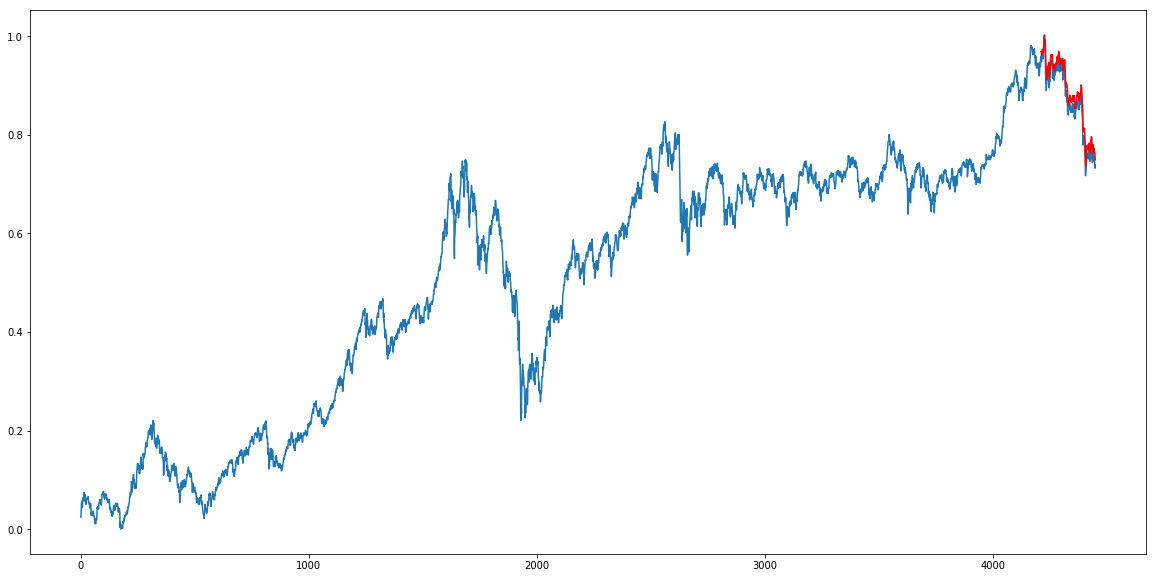

In [12]:
test_predict = model.predict(x_test)

plt.figure(figsize=(20,10))
plt.plot(price)

split_pt = train_test_split + window_size
plt.plot(np.arange(split_pt, split_pt + len(test_predict), 1), test_predict, color='r')